# Regularization in Machine Learning Models

**Yuanzhe(Roger) Li,  2020-01-07**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

# Outline
- Regularized Regression
    - Ridge Regression
    - LASSO
    - `glmnet`/`ElasticNet`
- (Tentative header) Structured Sparsity

# Regularized Regression
## Linear regression recap

Recall that in the context of linear regression $\mathbf{y} = \mathbf{X \beta} + \mathbf{\epsilon}$ where $\epsilon_i \overset{\text{iid}}{\sim} \mathcal{N}(0,\sigma^2)$.

Say $\mathbf{y} \in \mathbb{R}^n$, the negative log-likelihood is 
$$L(\mathbf{\beta}|\mathbf{X, y}) = \dfrac{n}{2}\log (2\pi \sigma^2) + \dfrac{1}{2\sigma^2}\sum_{i=1}^n(y_i -\mathbf{x}_i^T\mathbf{\beta})^2$$
Notice that the **MLE** is also the least squares soltion 
$$\mathbf{\beta}^* = \mathbf{\beta}_{\text{MLE}} = \mathbf{\beta}_{\text{LS}} = \underset{\mathbf{\beta}}{\text{arg min}}\sum_{i=1}^n(y_i -\mathbf{x}_i^T\mathbf{\beta})^2$$ 

## Linear regression recap (continued)
In matrix form 
$$\begin{align}
\mathbf{\beta}^* & = \underset{\mathbf{\beta}}{\text{arg min}} [(\mathbf{y - X\beta})^T(\mathbf{y - X\beta})] \\ 
& = \underset{\mathbf{\beta}}{\text{arg min}}[\mathbf{y}^T\mathbf{y} -2\mathbf{\beta}^T\mathbf{X}^T\mathbf{y} + \mathbf{\beta}^T \mathbf{X}^T\mathbf{X \beta}]  \end{align}$$
Denote $\mathbf{e} = \mathbf{y - X\beta} $, and set 

$$\dfrac{\partial \mathbf{e}^T \mathbf{e}}{\partial \mathbf{\beta}} = -2 \mathbf{X}^T\mathbf{y} + 2 \mathbf{X}^T\mathbf{X}\mathbf{\beta} = \mathbf{0}$$

we have 
$$
\begin{align}
& \mathbf{X}^T\mathbf{X}\mathbf{\beta} = \mathbf{X}^T\mathbf{y} \\ 
\Rightarrow \quad & \mathbf{\beta}^* = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T \mathbf{y}
\end{align}
$$

## Penalized loss function
The loss function of regularized regression takes the following form:

$$Loss(\mathbf{\beta}) = \mathbf{E}(\mathbf{\beta}) + \frac{\lambda}{2} \cdot \mathbf{P}(\mathbf{\beta})$$
where 

- $\mathbf{E}(\mathbf{\beta}) = \dfrac{1}{2}\sum_{i=1}^n(y_i -\mathbf{x}_i^T\mathbf{\beta})^2$ is the sum-of-squares error,
- $\mathbf{P}$ is a penalty function that aims at regularizing the unknown parameters, and 
- $\lambda$ is a hyperparameter that controls the tradeoff between the two components of the loss function.

## Ridge regression
### Penalty
One choice of $P_\lambda$ that favors small regression coefficients is to penalize the sum of squares of the regression coefficients:

$$P (\mathbf{\beta}) = \sum_{j=1}^p\beta_j^2$$

and the whole loss function becomes

$$Loss(\mathbf{\beta}) = \frac{1}{2}\sum_{i=1}^n(y_i -\mathbf{x}_i^T\mathbf{\beta})^2 + \frac{\lambda}{2}\sum_{j=1}^p\beta_j^2$$

which is known as ***ridge regression*** in statistics.

## Ridge regression
### Solution

Since the loss function of ridge regression is differentiable, it has a simple closed-form solution

$$\mathbf{\beta}_{\text{ridge}} = (\mathbf{X}^T\mathbf{X} + \lambda \mathbf{I})^{-1}\mathbf{X}^T \mathbf{y}$$

The solution is similar to the least squares solution with an extra diagonal matrix (i.e., $\lambda \mathbf{I}$) to be inverted, which improves the numeric stability of the system when $\mathbf{X}^T\mathbf{X}$ is close to being non-invertible 

*Question: what does that mean in practice?*




## Ridge regression
### A simple example

In [2]:
# Generate data
np.random.seed(2)
x1 = np.random.normal(size=20)
x2 = np.random.normal(loc = x1, scale=0.01, size=20)
y = np.random.normal(loc = 3 + x1 + x2, size=20)
design_mat = np.hstack((
    np.array(x1).reshape(20,1), 
    np.array(x2).reshape(20,1)
))

In [3]:
# Train an OLS model
reg_ols = linear_model.LinearRegression()
reg_ols.fit(design_mat, y)
reg_ols.coef_

array([ 14.51690508, -12.25821163])

In [4]:
# Use ridge penalty
reg_ridge = linear_model.Ridge(alpha = 1.0)
reg_ridge.fit(design_mat, y)
reg_ridge.coef_

array([1.10585803, 1.08303544])

## Ridge regression
### Bayesian justification for the ridge penalty

- (**TL;DR**) Regularized least square with ridge penalty is equivalent to the maximum a posteriori (MAP) estimator (up to constant factor) in the Bayesian framework for linear regression with istropic zero-mean Gaussian priors on the parameters. 

### Bayesian framework
- Linear regression in the context of Bayesian inference, in which a prior distribution over the model's parameters $\mathbf{\beta}$ is assumed, and the goal is to find the posterior distribution of the $\mathbf{\beta}$.

- Let $p(\mathbf{y}|\mathbf{\beta})$ denote the distribution of $\mathbf{y}$ given $\mathbf{\beta}$, and $p(\mathbf{\beta})$ the prior for $\mathbf{\beta}$, the posterior density is

$$p(\mathbf{\beta}|\mathbf{y}) = \dfrac{p(\mathbf{y}|\mathbf{\beta})p(\mathbf{\beta})}{p(\mathbf{y})} \propto p(\mathbf{y}|\mathbf{\beta})p(\mathbf{\beta})$$

or 

$$\log p(\mathbf{\beta}|\mathbf{y})  = \log p(\mathbf{y}|\mathbf{\beta}) + \log p(\mathbf{\beta}) + \text{constant}$$

- From a Bayesian perspective, one can think of the penalty as arising from a formal prior distribution on the parameters.

### Bayesian linear regression - setup

Let's revisit the linear model $\mathbf{y} = \mathbf{X \beta} + \mathbf{\epsilon}$ where $\epsilon_i \overset{\text{iid}}{\sim} \mathcal{N}(0, \tau^{-1})$ with a bayesian treatment as follows:

- Prior $\mathbf{\beta} \sim \mathcal{N}(\mathbf{m_0, S_0})$
- Likelihood $p(\mathbf{y}|\mathbf{\beta}) = \sum_{i=1}^n \mathcal{N}(y_i|\mathbf{x_i}^T\mathbf{\beta}, \tau^{-1})$
- Posterior $\mathbf{\beta}|\mathbf{y} \sim \mathcal{N}(\mathbf{\beta}|\mathbf{m_n, S_n})$

Notice that Gaussian is [self-conjugate](https://en.wikipedia.org/wiki/Conjugate_prior) for Gaussian likelihood function, we can use the fact that the posterior is also Gaussian to figure out the parameterization.

### Bayesian linear regression - posterior

- For the posterior distribution, we have 

$$
\begin{align}
\mathbf{m_n} &= \mathbf{S_n(S_0^{-1}\mathbf{m_0} + \tau\mathbf{X}^T\mathbf{y}})\\
\mathbf{S_n}^{-1} &= \mathbf{S_0}^{-1} + \tau \mathbf{X}^T\mathbf{X}
\end{align}
$$

- Assume the prior is a zero-mean isotropic Gaussian, i.e., $\mathbf{\beta} \sim \mathcal{N}(\mathbf{0}, \alpha^{-1}\mathbf{I})$. The parameterization of the posterior then becomes

$$
\begin{align}
\mathbf{m_n} &= \tau \mathbf{S_n X}^T\mathbf{y}\\
\mathbf{S_n}^{-1} &= \alpha \mathbf{I} + \tau \mathbf{X}^T\mathbf{X}
\end{align}
$$

### Connection between bayesian linear regression and ridge regression

- Since the posterior is Gaussian, we have 

$$\mathbf{\beta}_{\text{MAP}} = \mathbf{m_n} = (\mathbf{X}^T\mathbf{X} + \dfrac{\alpha}{\tau}\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$$ 

which is the same as the ridge solution $(\mathbf{X}^T\mathbf{X} + \lambda \mathbf{I})^{-1}\mathbf{X}^T \mathbf{y}$ with $\lambda = \alpha / \tau$.


- Alternatively, if we compare the objective fuctions. Maximization of the log of the posterior probability below w.r.t $\mathbf{\beta}$

$$
\begin{align}
\log p(\mathbf{\beta}|\mathbf{y})  &= \log p(\mathbf{y}|\mathbf{\beta}) + \log p(\mathbf{\beta}) + \text{constant}\\
&= - \dfrac{\tau}{2}\sum_{i=1}^{n}(y_i -\mathbf{x}_i^T\mathbf{\beta})^2 - \dfrac{\alpha}{2}\mathbf{\beta}^T
\mathbf{\beta} + \text{constant}
\end{align}
$$

again, is equivalent to the minimization of the regularized (ridge penalty) least squares with $\lambda = \alpha / \tau$.



### Bayesian versus frequentist view
- Notice that when the prior is infinitely broad, i.e., $\mathbf{S_0}=\alpha^{-1}\mathbf{I}$ and $\alpha \rightarrow 0$, $\mathbf{\beta}_{\text{MAP}}$ is the same as the MLE estimator.

$$\lim_{\alpha \rightarrow 0}\mathbf{\beta}_{\text{MAP}} = \lim_{\alpha \rightarrow 0}[(\mathbf{X}^T\mathbf{X} + \dfrac{\alpha}{\tau}\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}] = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y} = \mathbf{\beta}_{\text{MLE}}$$

- Despite of the connection between  $\mathbf{\beta}_{\text{MAP}}$ and $\mathbf{\beta}_{\text{ridge}}$ or $\mathbf{\beta}_{\text{MLE}}$ , the similarity between Bayesian and Frequentist breaks down in other inferential respects.

### Choosing $\lambda$ in ridge regression
- Common model fitness measures for OLS such as [Mallows's $C_p$](https://en.wikipedia.org/wiki/Mallows%27s_Cp), [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion), and [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) also work for ridge regression.
- In practice, we can use k-fold cross validation to select $\lambda$ with the CV performance.

### Example of using cross validation to choose $\lambda$ for ridge regression

- Let's use simulated data with 15 features with `effective_rank = 5`

In [5]:
from sklearn.datasets import make_regression
X, y, true_coef = make_regression(n_samples=1000, n_features=20, effective_rank = 3, coef=True, 
                          n_informative = 15, noise = 0.5, random_state=123)

In [6]:
def plot_ridge_cv(reg_cv, dpi=100):
    """Plot mean and sd of cv scores from a GridSearchCV for ridge regression"""
    param = list(reg_cv.param_grid.keys())[0]
    grid = np.log(reg_cv.param_grid[param])
    score, std = reg_cv.cv_results_['mean_test_score'], reg_cv.cv_results_['std_test_score']
    best_param, best_score = reg_cv.best_params_['alpha'], reg_cv.best_score_
    fig, ax=plt.subplots(dpi=dpi)
    ax.errorbar(grid, -score, yerr=std)
    ax.set_xlabel(r'$\log(\lambda)$')
    ax.set_ylabel("Root mean-squared error")
    ax.set_xticks(np.arange(-20,10,2))
    title = r'Best $\log(\lambda)$' + f': {round(np.log(best_param),3)}, best ' + r'$\overline{rmse}$' + f': {round(-best_score, 3)}'
    ax.set_title(title)
    ax.plot()

In [7]:
np.random.seed(20)
reg_ridge = linear_model.Ridge()
params = {
    'alpha': np.exp(np.arange(-20,6,2))
}
reg_cv = GridSearchCV(reg_ridge, params, scoring = 'neg_root_mean_squared_error', cv=10)

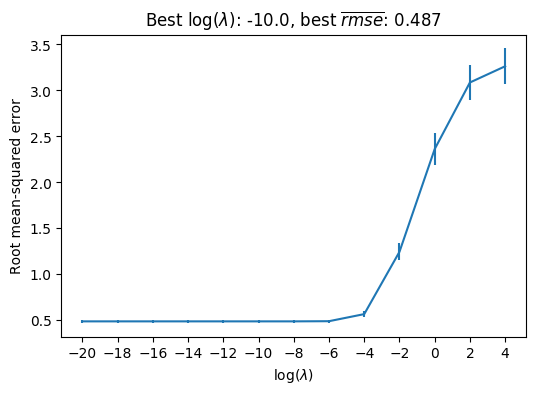

In [8]:
reg_cv.fit(X, y)
plot_ridge_cv(reg_cv)

- Huber regression is a robust regression method that uses the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which applies a linear loss (as opposed to quadratic loss) to samples that are classified as outliers (i.e., absolute error $> \epsilon$)
- In scikit-learn, the [`HuberRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html#sklearn.linear_model.HuberRegressor) minimizes the following loss function:

$$\min_{\omega, \sigma} \sum_{i=1}^n(\sigma + H_\epsilon(\frac{X_i\omega - y_i}{\sigma})\sigma) + \alpha ||\omega||_2^2$$

where $H_\epsilon(z) = z^2 \text{ if } |z| < \epsilon$, and $H_\epsilon(z) = \epsilon|z| - \epsilon^2 \text{ otherwise}$.